In [1]:
import numpy as np
import pandas as pd

import transformers
from transformers import BertTokenizer, BertModel, BertConfig
from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
from huggingface_hub import login
 
import torch
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, roc_auc_score, multilabel_confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib as plt

In [2]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [4]:
#login()

In [6]:
#train = pd.read_csv('datasets/gendered_og_train.csv')
train = pd.read_csv("datasets/gendered_train.csv")
#train = pd.read_csv("datasets/all_back_trans_train.csv")
#gendered_val = pd.read_csv("datasets/gendered_val.csv")
val = pd.read_csv("datasets/val-with-categories.csv")
#val = pd.read_csv('datasets/gendered_og_val.csv')
#val = pd.read_csv('datasets/gendered_val.csv')
test = pd.read_csv("datasets/test-with-categories.csv")
#test = pd.read_csv("datasets/test-with-severities-and-multilabels.csv")

In [7]:
#for cross validation train and val are concatenated

#train = pd.concat([train, val], ignore_index=True)
#gendered_train = pd.concat([gendered_train, gendered_val], ignore_index=True)

In [8]:
#Gendered depressed original control dataset

#train_control = train[train['Label']==0]
#train_depressed = gendered_train[gendered_train['Label']==1]
#train = pd.concat([train_control, train_depressed], ignore_index=True)

#val_control = val[val['Label']==0]
#val_depressed = gendered_val[gendered_val['Label']==1]
#val = pd.concat([val_control, val_depressed], ignore_index=True)

In [9]:
len(train)

824

In [12]:
pd.set_option('display.max_columns', None)

In [13]:
train = train[train['Label'].notna()]
train = train[train['Sentence'].notna()]

test = test[test['Label'].notna()]
test = test[test['Sentence'].notna()]

val = val[val['Label'].notna()]
val = val[val['Sentence'].notna()]

In [17]:
train.head()

,Sentence,Label,Severity,Sadness,Pessimism,Sense_of_failure,Loss_of_Pleasure,Guilty_feelings,Sense_of_punishment,Self-dislike,Self-incrimination,Suicidal_ideas,Crying,Agitation,Social_withdrawal,Indecision,Feelings_of_worthlessness,Loss_of_energy,Change_of_sleep,Irritability,Changes_in_appetite,Concentration_difficulty,Tiredness_or_fatigue,Loss_of_interest_in_sex,Subject,Gender
0,"""I am error.",1,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Subject 2432,0
1,"I have no motivation for school, no motivation...",1,3,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Subject 2432,0
2,"In my head, I feel that any reason that I come...",1,3,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Subject 2432,0
3,I have said a couple things without thinking o...,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Subject 2432,0
4,I thought about this way too much for my own g...,1,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Subject 2432,0


In [18]:
len(train)

824

In [19]:
train.columns[3:24]

Index(['Sadness', 'Pessimism', 'Sense_of_failure', 'Loss_of_Pleasure',
       'Guilty_feelings', 'Sense_of_punishment', 'Self-dislike',
       'Self-incrimination', 'Suicidal_ideas', 'Crying', 'Agitation',
       'Social_withdrawal', 'Indecision', 'Feelings_of_worthlessness',
       'Loss_of_energy', 'Change_of_sleep', 'Irritability',
       'Changes_in_appetite', 'Concentration_difficulty',
       'Tiredness_or_fatigue', 'Loss_of_interest_in_sex'],
      dtype='object')

In [20]:
gender_indices = list(range(3,24)) + [25]

In [21]:
train['list'] = train[train.columns[3:24]].values.tolist()
#train['list'] = train[train.columns[24:29]].values.tolist()
#train['list'] = train[train.columns[26:31]].values.tolist()
new_train = train[['Sentence', 'list']].copy()

#uncomment if val exists
val['list'] = val[val.columns[24:29]].values.tolist()
new_val = val[['Sentence', 'list']].copy()

#test['list'] = test[test.columns[3:24]].values.tolist()
test['list'] = test[test.columns[24:29]].values.tolist()
new_test = test[['Sentence', 'list']].copy()

new_train.head()

,Sentence,list
0,"""I am error.","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"I have no motivation for school, no motivation...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
2,"In my head, I feel that any reason that I come...","[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,I have said a couple things without thinking o...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,I thought about this way too much for my own g...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [22]:
#train['list2'] = train[train.columns[gender_indices]].values.tolist()
train['labelgen'] = train[train.columns[[1]+ [25]]].values.tolist()

In [23]:
new_train.loc[0, "list"]

[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [24]:
model_checkpoint = "mental/mental-bert-base-uncased"

**Dataset and Dataloader**

In [25]:
# hyperparameters as used by the BDI-Sen authors
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 2e-05
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

torch.manual_seed(10)

In [26]:
#class to tokenize the data and create the dataset for the model

class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.Sentence
        self.targets = dataframe.list
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [27]:
#creating the datasets

training_set = CustomDataset(new_train, tokenizer, MAX_LEN)
#uncomment if val exists
eval_set = CustomDataset(new_val, tokenizer, MAX_LEN)
testing_set = CustomDataset(new_test, tokenizer, MAX_LEN)

In [28]:
training_set[0]

{'ids': tensor([ 101, 1000, 1045, 2572, 7561, 1012,  102,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]),
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0,

**Fine-tuning**

In [29]:
#creating the customized model, by adding a drop out and a linear layer to get the final output for the model

class MBERTClass(torch.nn.Module):
    def __init__(self):
        super(MBERTClass, self).__init__()
        self.l1 = AutoModel.from_pretrained(model_checkpoint)
        self.l2 = torch.nn.Dropout(0.2)
        self.l3 = torch.nn.Linear(768, 21)
        #self.l3 = torch.nn.Linear(768, 5)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

In [30]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [31]:
def trainer(epoch, loader):
    model.train()
    for _,data in enumerate(loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)
        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)        
        
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        loss.backward()
        optimizer.step()

In [32]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
              }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_loader = DataLoader(testing_set, **test_params)

In [33]:
#uncomment if not cross validation

model = MBERTClass()
model.to(device)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

train_loader = DataLoader(training_set, **train_params)
val_loader = DataLoader(eval_set, **val_params)
test_loader = DataLoader(testing_set, **test_params)

for epoch in range(EPOCHS):
    trainer(epoch, train_loader)

Some weights of BertModel were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch: 0, Loss:  0.6894130706787109
Epoch: 1, Loss:  0.32521042227745056
Epoch: 2, Loss:  0.2330925166606903
Epoch: 3, Loss:  0.17695081233978271
Epoch: 4, Loss:  0.16197896003723145
Epoch: 5, Loss:  0.19963927567005157
Epoch: 6, Loss:  0.17623507976531982
Epoch: 7, Loss:  0.14821521937847137
Epoch: 8, Loss:  0.13881979882717133
Epoch: 9, Loss:  0.12607227265834808
Epoch: 10, Loss:  0.1354781538248062
Epoch: 11, Loss:  0.11718714982271194
Epoch: 12, Loss:  0.15083596110343933
Epoch: 13, Loss:  0.11246677488088608
Epoch: 14, Loss:  0.10474345833063126
Epoch: 15, Loss:  0.08895044773817062
Epoch: 16, Loss:  0.09132183343172073
Epoch: 17, Loss:  0.07482117414474487
Epoch: 18, Loss:  0.071526437997818
Epoch: 19, Loss:  0.06709839403629303


In [34]:
torch.save(model, 'gendered-mBERT.pt')

**Testing**

In [34]:
model = torch.load('irr-syn-eda-3-mBERT.pt')
# check model summary
model.eval()

MBERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [35]:
model.eval()
fin_targets=[]
fin_outputs=[]
with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
outputs, targets = fin_outputs, fin_targets
outputs = (np.array(outputs) >= 0.5).astype(int)
targets = [[int(num) for num in sublist] for sublist in targets]
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro', zero_division = 0.0)
f1_score_macro = metrics.f1_score(targets, outputs, average='macro', zero_division = 0.0)
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted', zero_division = 0.0)
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")
    
precision_micro = precision_score(targets, outputs, average='micro', zero_division = 0.0)
precision_macro = precision_score(targets, outputs, average='macro', zero_division = 0.0)
recall_micro = recall_score(targets, outputs, average='micro', zero_division = 0.0)
recall_macro = recall_score(targets, outputs, average='macro', zero_division = 0.0)
    
print(f"Precision (Micro) = {precision_micro}")
print(f"Precision (Macro) = {precision_macro}")
print(f"Recall (Micro) = {recall_micro}")
print(f"Recall (Macro) = {recall_macro}")    
    
auc_micro = roc_auc_score(targets, outputs, average='micro')
print(f"AUC = {auc_micro}")

Accuracy Score = 0.8
F1 Score (Micro) = 0.8765743073047859
F1 Score (Macro) = 0.7788560205226873
F1 Score (Weighted) = 0.8623300310800311
Precision (Micro) = 0.9206349206349206
Precision (Macro) = 0.8297684027497693
Recall (Micro) = 0.8365384615384616
Recall (Macro) = 0.7440404487153712
AUC = 0.916038415778154


In [ ]:
outputs, targets = fin_outputs, fin_targets
outputs = (np.array(outputs) >= 0.3).astype(int)
targets = [[int(num) for num in sublist] for sublist in targets]
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro', zero_division = 0.0)
f1_score_macro = metrics.f1_score(targets, outputs, average='macro', zero_division = 0.0)
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted', zero_division = 0.0)
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")
    
precision_micro = precision_score(targets, outputs, average='micro', zero_division = 0.0)
precision_macro = precision_score(targets, outputs, average='macro', zero_division = 0.0)
recall_micro = recall_score(targets, outputs, average='micro', zero_division = 0.0)
recall_macro = recall_score(targets, outputs, average='macro', zero_division = 0.0)
    
print(f"Precision (Micro) = {precision_micro}")
print(f"Precision (Macro) = {precision_macro}")
print(f"Recall (Micro) = {recall_micro}")
print(f"Recall (Macro) = {recall_macro}")    
    
auc_micro = roc_auc_score(targets, outputs, average='micro')
print(f"AUC = {auc_micro}")

Accuracy Score = 0.6923076923076923
F1 Score (Micro) = 0.5470085470085471
F1 Score (Macro) = 0.23496767349226363
F1 Score (Weighted) = 0.46804695067346525
Precision (Micro) = 0.6666666666666666
Precision (Macro) = 0.32915787004456953
Recall (Micro) = 0.463768115942029
Recall (Macro) = 0.21130201751319763
AUC = 0.728101552060849


In [ ]:
for i in range(len(targets[0])):
    symptom_targets = [symptom[i] for symptom in targets]
    symptom_outputs = [symptom[i] for symptom in outputs]
    #accuracy = metrics.accuracy_score(symptom_targets, symptom_outputs)
    f1_score = metrics.f1_score(symptom_targets, symptom_outputs, zero_division = 0.0)
    print('\nSymptom: ', test.columns[i+3])
    #print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score = {f1_score}")
    
    precision = precision_score(symptom_targets, symptom_outputs, zero_division = 0.0)
    recall = recall_score(symptom_targets, symptom_outputs, zero_division = 0.0)
    
    print(f"Precision = {precision}")
    print(f"Recall = {recall}")  
    
    try:
        auc = roc_auc_score(symptom_targets, symptom_outputs)
        print(f"AUC = {auc}")
    except ValueError:
        pass


Symptom:  Sadness
F1 Score = 0.7916666666666666
Precision = 0.76
Recall = 0.8260869565217391
AUC = 0.8968272620446534

Symptom:  Pessimism
F1 Score = 0.9333333333333333
Precision = 0.875
Recall = 1.0
AUC = 0.9975124378109453

Symptom:  Sense_of_failure
F1 Score = 0.8571428571428571
Precision = 0.8571428571428571
Recall = 0.8571428571428571
AUC = 0.9260838663823739

Symptom:  Loss_of_Pleasure
F1 Score = 0.8620689655172413
Precision = 0.8333333333333334
Recall = 0.8928571428571429
AUC = 0.9325396825396824

Symptom:  Guilty_feelings
F1 Score = 0.0
Precision = 0.0
Recall = 0.0
AUC = 0.5

Symptom:  Sense_of_punishment
F1 Score = 0.0
Precision = 0.0
Recall = 0.0

Symptom:  Self-dislike
F1 Score = 0.6666666666666666
Precision = 0.8333333333333334
Recall = 0.5555555555555556
AUC = 0.7752652149637075

Symptom:  Self-incrimination
F1 Score = 0.0
Precision = 0.0
Recall = 0.0

Symptom:  Suicidal_ideas
F1 Score = 0.9411764705882353
Precision = 1.0
Recall = 0.8888888888888888
AUC = 0.94444444444444

c:\Users\larag\anaconda3\envs\Thesis\Lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


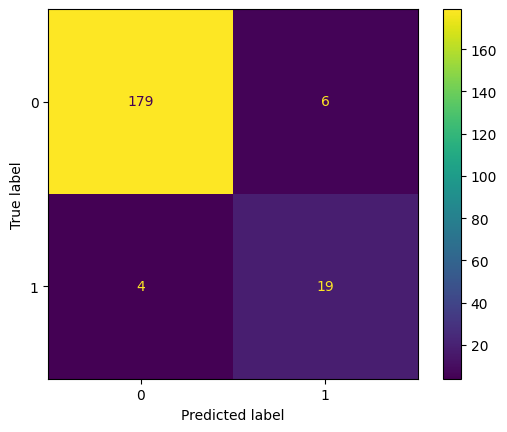

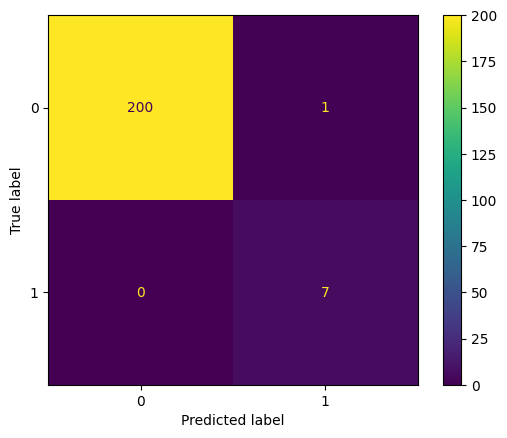

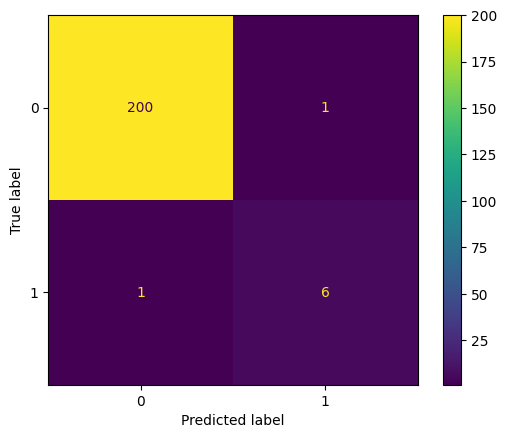

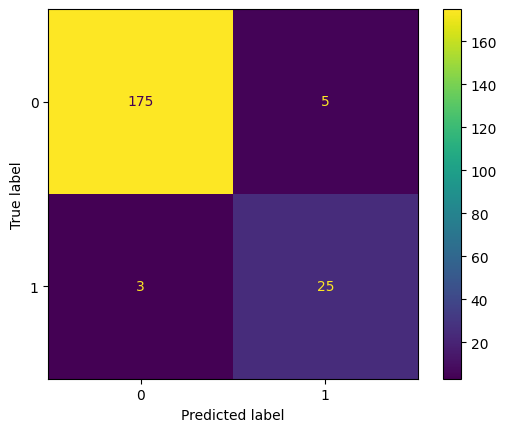

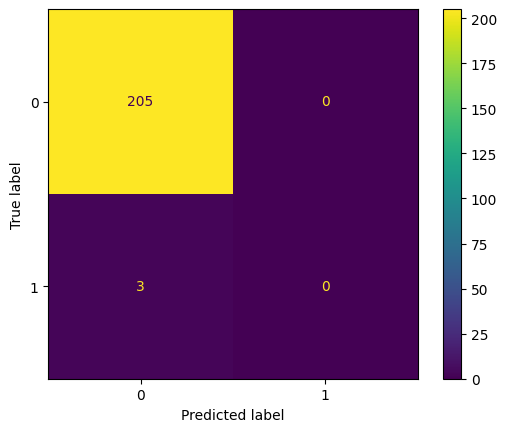

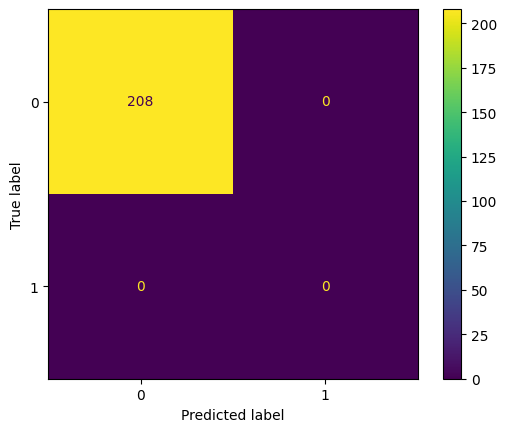

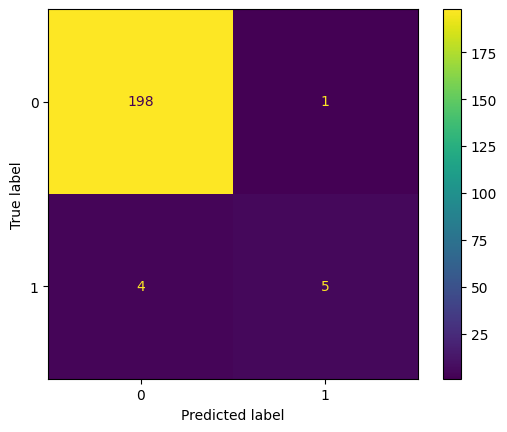

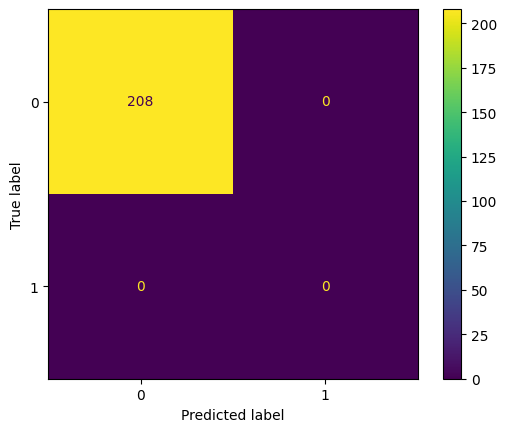

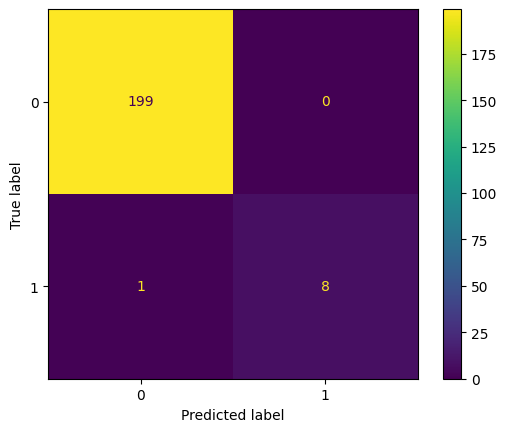

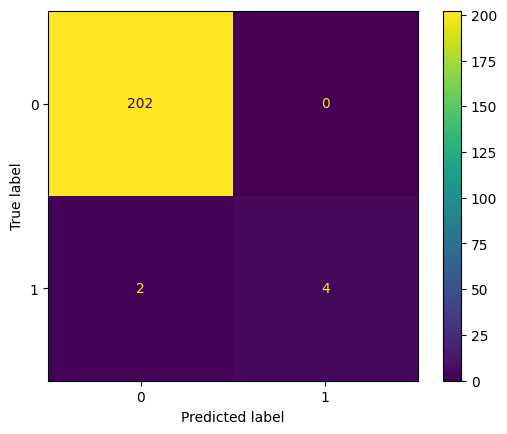

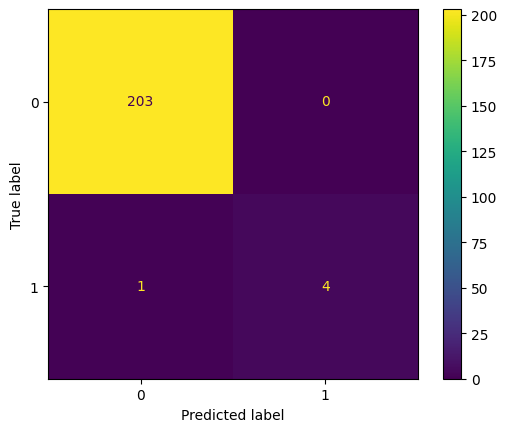

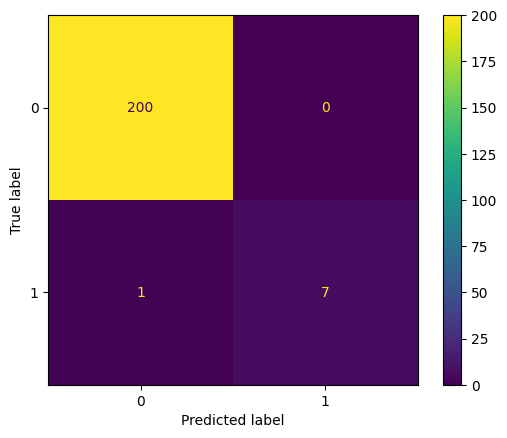

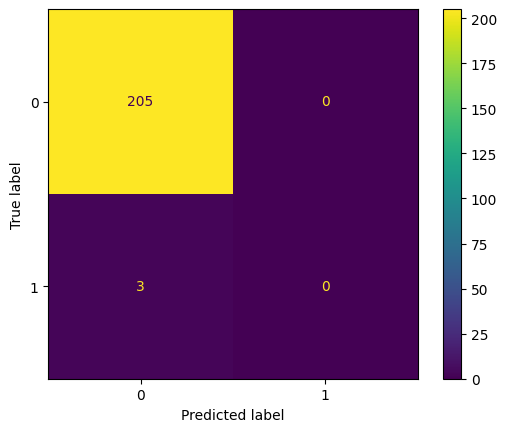

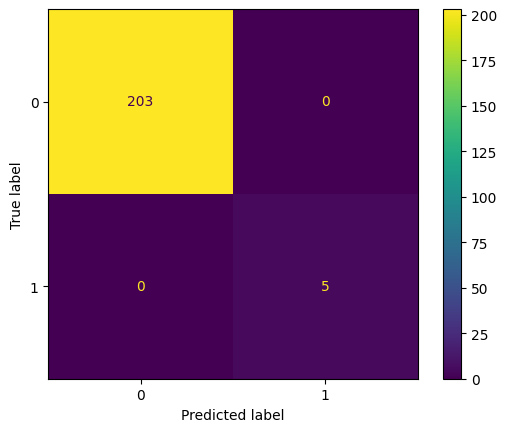

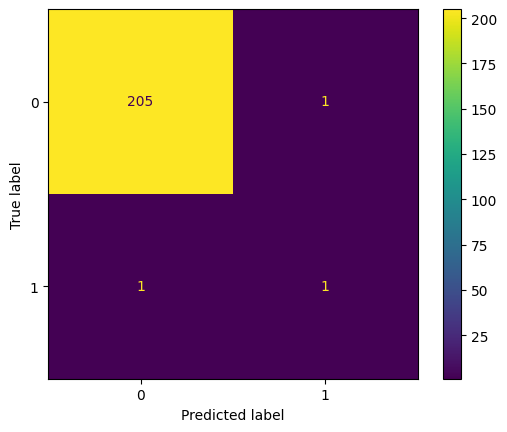

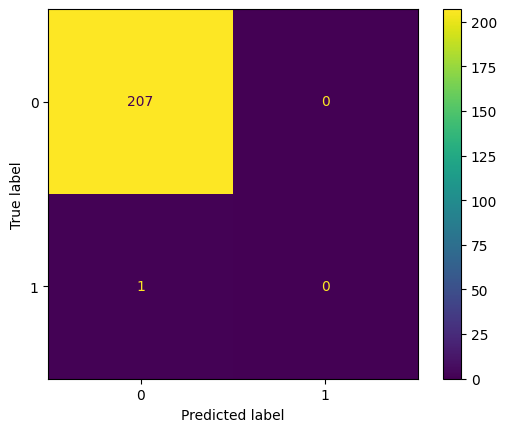

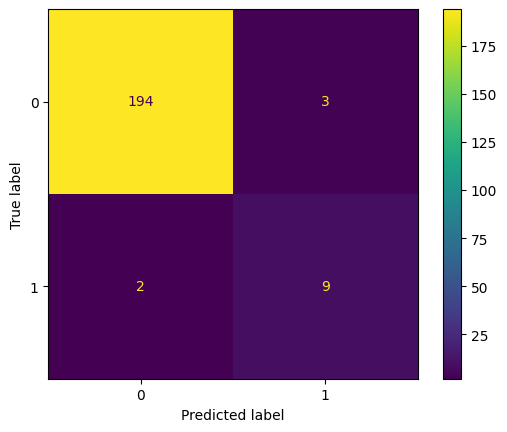

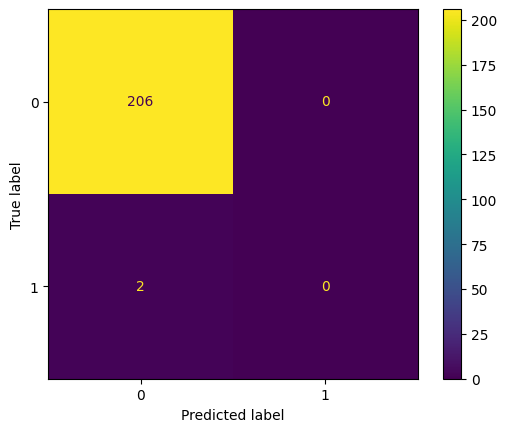

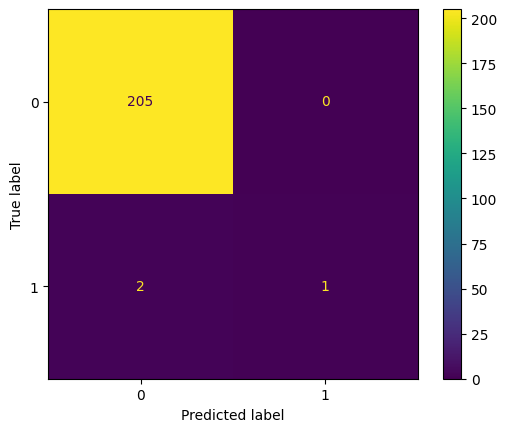

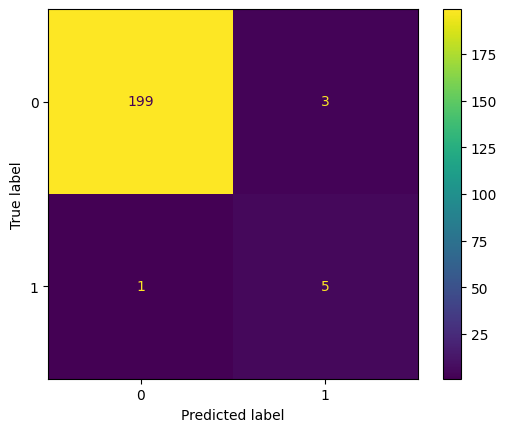

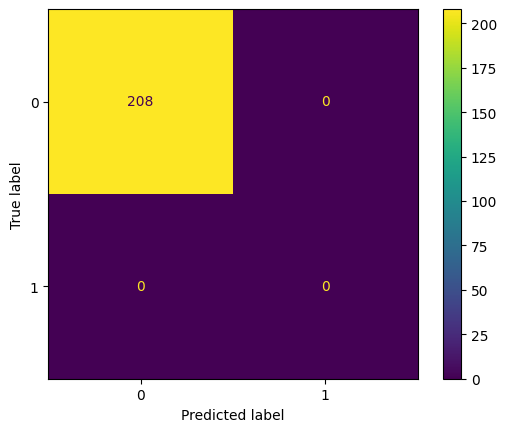

In [ ]:
cm = multilabel_confusion_matrix(targets, outputs)

for matrix in cm:
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()